<a href="https://colab.research.google.com/github/Haripriya585/Movie_Recommendation_System/blob/master/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

In [ ]:
md = pd. read_csv('/content/drive/My Drive/Project_26/Dataset/movies_metadata.csv')
credits = pd.read_csv('/content/drive/My Drive/Project_26/Dataset/credits.csv')
keywords = pd.read_csv('/content/drive/My Drive/Project_26/Dataset/keywords.csv')
links_small = pd.read_csv('/content/drive/My Drive/Project_26/Dataset/links_small.csv')
rt = pd.read_csv('/content/drive/My Drive/Project_26/Dataset/ratings_small.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
md.shape

(45466, 24)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [ ]:
md['popularity'] = md['popularity'].apply(clean_numeric).astype('float')
md['vote_count'] = md['vote_count'].apply(clean_numeric).astype('float')
md['vote_average'] = md['vote_average'].apply(clean_numeric).astype('float')

In [ ]:
md['popularity'].describe()

count    45460.000000
mean         2.921478
std          6.005414
min          0.000000
25%          0.385948
50%          1.127685
75%          3.678902
max        547.488298
Name: popularity, dtype: float64

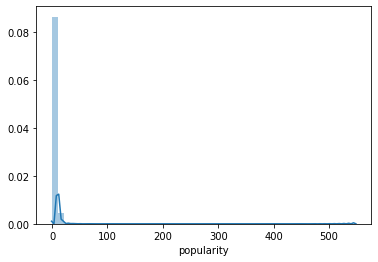

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:347: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)


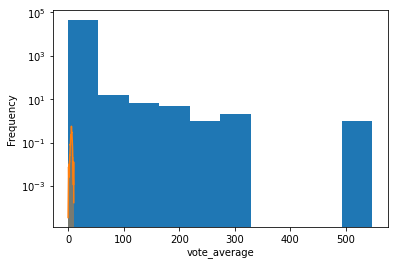

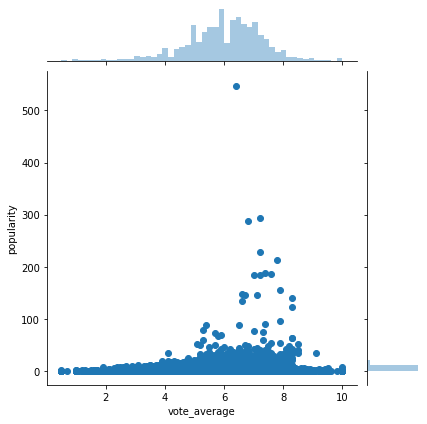

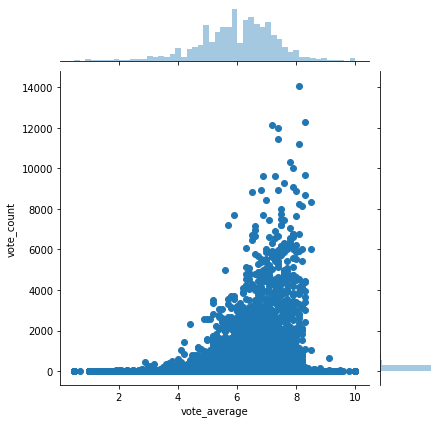

In [ ]:
sns.distplot(md['popularity'].fillna(md['popularity'].median()))
plt.show()
md['popularity'].plot(logy=True, kind='hist')
md['vote_count'].describe()
md['vote_average'] = md['vote_average'].replace(0, np.nan)
md['vote_average'].describe()
sns.distplot(md['vote_average'].fillna(md['vote_average'].median()))
sns.jointplot(x='vote_average', y='popularity', data=md)
sns.jointplot(x='vote_average', y='vote_count', data=md)



**Simple** **Recommender**

In [ ]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
md = md.drop([19730, 29503, 35587])
md['id'] = md['id'].astype('int')
fmd = md[md['id'].isin(links_small)]


In [ ]:

vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
m = vote_counts.quantile(0.95)
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()

In [ ]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return round((v/(v+m) * R) + (m/(m+v) * C),2)

In [ ]:
def qualified(movies):
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values(['wr',"popularity"], ascending=False).head(10)
    return qualified

In [ ]:
def simpleRecommender():
  mdf = md[['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
  qualifi = qualified(mdf)
  return qualifi

**Content** **Based**

In [ ]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')
fmd = md[md['id'].isin(links_small)]
fmd['cast'] = fmd['cast'].apply(literal_eval)
fmd['crew'] = fmd['crew'].apply(literal_eval)
fmd['keywords'] = fmd['keywords'].apply(literal_eval)
fmd['cast_size'] = fmd['cast'].apply(lambda x: len(x))
fmd['crew_size'] = fmd['crew'].apply(lambda x: len(x))



In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
fmd['director'] = fmd['crew'].apply(get_director)
fmd['director'] = fmd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
fmd['director'] = fmd['director'].apply(lambda x: [x,x, x])
fmd['cast'] = fmd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
fmd['cast'] = fmd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
fmd['cast'] = fmd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
fmd['keywords'] = fmd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
s = fmd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
s = s.value_counts()
s = s[s > 1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
stemmer = SnowballStemmer('english')
fmd['keywords'] = fmd['keywords'].apply(filter_keywords)
fmd['keywords'] = fmd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
fmd['keywords'] = fmd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
fmd['soup'] = fmd['keywords'] + fmd['cast'] + fmd['director'] + fmd['genres']
fmd['soup'] = fmd['soup'].apply(lambda x: ' '.join(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
def tiles_indices():
  titles = fmd['title']
  indices = pd.Series(fmd.index, index=fmd['title'])
  return titles,indices

In [ ]:

count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(fmd['soup'])
cos_sim = cosine_similarity(count_matrix, count_matrix)


In [ ]:
def get_recommendations(title):
    titles = tiles_indices()[0]
    indices = tiles_indices()[1]
    idx = indices[title]
    cos_scores = list(enumerate(cos_sim[idx]))
    cos_scores = sorted(cos_scores, key=lambda x: x[1], reverse=True)
    cos_scores = cos_scores[1:50]
    movie_indices = [i[0] for i in cos_scores]
    return titles.iloc[movie_indices],movie_indices

In [ ]:
get_recommendations('Toy Story')[0].head(10)

10754                Luxo Jr.
3024              Toy Story 2
17551                  Cars 2
11074                    Cars
2262             A Bug's Life
22126    Toy Story of Terror!
15519             Toy Story 3
3336        Creature Comforts
4797           Monsters, Inc.
1738         Meet the Deedles
Name: title, dtype: object

In [ ]:
def improved_recommendations(title):
    movie_indices = get_recommendations(title)[1]
    movies = fmd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year',"popularity"]]
    return qualified(movies)

In [ ]:
improved_recommendations('Toy Story')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,title,vote_count,vote_average,year,popularity,wr
13875,Up,7048,7,2009,19.330884,6.92
4797,"Monsters, Inc.",6150,7,2001,26.419962,6.91
21361,Despicable Me 2,4729,7,2013,24.823550,6.88
15519,Toy Story 3,4710,7,2010,16.966470,6.88
3024,Toy Story 2,3914,7,1999,17.547693,6.86
22915,The Lego Movie,3127,7,2014,16.418133,6.83
3918,The Emperor's New Groove,1544,7,2000,12.297375,6.70
608,The Aristocats,1287,7,1970,9.834047,6.65
14550,Fantastic Mr. Fox,1206,7,2009,8.695893,6.63
3389,The Road to El Dorado,892,7,2000,8.755188,6.55



**Collabarative**


In [ ]:

d1=pd.read_csv('/content/drive/My Drive/Project_26/Dataset/movies_metadata.csv')
d2=pd.read_csv('/content/drive/My Drive/Project_26/Dataset/links.csv')
X1 = d1.drop('adult',axis=1)
X2 = X1.drop('homepage',axis=1)
X3 = X2.drop('original_language',axis=1)
X4 = X3.drop('overview',axis=1)
# X5 = X4.drop('poster_path',axis=1)
X6 = X4.drop('production_companies',axis=1)
X7 = X6.drop('production_countries',axis=1)
X8 = X7.drop('spoken_languages',axis=1)
X9 = X8.drop('tagline',axis=1)
y = X9.drop('belongs_to_collection',axis=1)
y1 = y.drop('runtime',axis=1)
y2 = y1.drop('video',axis=1)
y3 = y2.drop('release_date',axis=1)
y4 = y3.drop('poster_path',axis=1)
y5 = y4.drop('original_title',axis=1)
y5 = y5.drop('budget',axis=1)
y5 = y5.drop('imdb_id',axis=1)
y5 = y5.drop('popularity',axis=1)
y5 = y5.drop('revenue',axis=1)
y5 = y5.drop('status',axis=1)
y5 = y5.drop('vote_average',axis=1)
y5 = y5.drop('vote_count',axis=1)
y5 = y5.drop('genres',axis=1)



data = y5.rename(columns={'id': 'tmdbId'})
data['tmdbId'] = d2.tmdbId.astype(float)
collmovies = pd.merge(data, d2)
collmovies = collmovies.drop("imdbId",axis=1)
collmovies= collmovies.drop("tmdbId",axis =1)
collmovies

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,title,movieId
0,Toy Story,1
1,Jumanji,2
2,Grumpier Old Men,3
3,Waiting to Exhale,4
4,Father of the Bride Part II,5
...,...,...
93264,Subdue,175367
93265,Century of Birthing,175369
93266,Betrayal,175371
93267,Satan Triumphant,175373


In [ ]:

# collmovies=clean_merge()
ratings = pd.merge(collmovies, rt)
ratings= ratings.drop("timestamp",axis =1)
userRatings = ratings.pivot_table(index=['userId'],columns=['title'],values='rating')
userRatings = userRatings.dropna(thresh=1, axis=1).fillna(0,axis=1)
userRatings

title,$5 a Day,"'night, Mother",(500) Days of Summer,...All the Marbles,...And God Created Woman,...And Justice for All,...tick... tick... tick...,06/05,1,10,10 Items or Less,10 Rillington Place,100 Feet,100 Girls,100 Rifles,101 Dalmatians,102 Dalmatians,12 Angry Men,12 Days of Terror,120,13,13 Ghosts,13 Minutes,13 Rue Madeleine,1492: Conquest of Paradise,17 Girls,1776,18 Again!,1915,1941,2 Become 1,2 Days in the Valley,2 Guns,2 or 3 Things I Know About Her,20 Dates,"20,000 Leagues Under the Sea",200 Cigarettes,2001 Maniacs,2001: A Space Odyssey,2010,...,Zatôichi and the Chest of Gold,Zatôichi and the Doomed Man,Zatôichi the Fugitive,Zatôichi the Outlaw,Zatôichi's Flashing Sword,Zatôichi's Vengeance,Zazie dans le métro,Zebrahead,Zebraman,Zeitgeist: Addendum,Zelig,Zen Noir,Zero Kelvin,Zero for Conduct,Zeta One,Zeus & Roxanne,Zig Zag,Ziggy Stardust and the Spiders from Mars,Zombie Holocaust,Zombie Night,Zombie Strippers!,Zombie and the Ghost Train,Zombieland,Zone 39,"Zorro, The Gay Blade",Zouzou,Zozo,Zulu,Zurich,Zuzu Angel,[REC],[REC]³ Genesis,eCupid,eXistenZ,ivans xtc.,xXx: State of the Union,¡Three Amigos!,À Nous la Liberté,À la mode,Æon Flux
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
# def corMatrix():
# userRatings = pivot_table()
corrMatrix = userRatings.corr(method='pearson')
# return corrMatrix

In [ ]:
def get_similar(movie_name,rating):
    similar_ratings = corrMatrix[movie_name]*(rating-2.5)
    similar_ratings = similar_ratings.sort_values(ascending=False)
    #print(type(similar_ratings))
    return similar_ratings

In [ ]:
# def collfinding(movi,rat):
mvi_watching = [("Toy Story",4)]
similar_movies = pd.DataFrame()
for movie,rating in mvi_watching:
    similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)
similar_movies = similar_movies.sum().sort_values(ascending=False).head(20)
similar_movies

Toy Story                      1.500000
Cradle Will Rock               0.711211
Babe: Pig in the City          0.590699
Fantasia                       0.558557
Little Women                   0.548982
The Gate of Heavenly Peace     0.535314
Night Passage                  0.523412
Fire in the Sky                0.519099
The Animal                     0.516102
Bonnie and Clyde               0.480002
She's So Lovely                0.470022
Babe                           0.455379
Ben-Hur                        0.454652
Once Upon a Time in America    0.452531
Les Cousins                    0.449014
Moll Flanders                  0.445471
Guy                            0.445434
Little Buddha                  0.441179
Airplane II: The Sequel        0.437675
One, Two, Three                0.428785
dtype: float64

Mix

In [ ]:
mvi_count = rt.groupby("userId").size()
mvi_count

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Length: 671, dtype: int64

In [ ]:
id = 1
if mvi_count[id] < 50:
    recommendation = simpleRecommender()
    print(recommendation.head(10))
else: 
    Mix()

                                                   title  ...    wr
15651                                          Inception  ...  7.93
12589                                    The Dark Knight  ...  7.92
23076                                       Interstellar  ...  7.91
2870                                          Fight Club  ...  7.90
292                                         Pulp Fiction  ...  7.89
4904   The Lord of the Rings: The Fellowship of the Ring  ...  7.89
314                             The Shawshank Redemption  ...  7.88
351                                         Forrest Gump  ...  7.88
7069       The Lord of the Rings: The Return of the King  ...  7.88
5876               The Lord of the Rings: The Two Towers  ...  7.87

[10 rows x 7 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [ ]:
id = 3
if mvi_count[id] < 50:
    recommendation = simpleRecommender()
    print(recommendation.head(10))
else: 
    cont_list = improved_recommendations("Toy Story")
    print(cont_list.title)
    print(similar_movies)

13875                          Up
4797               Monsters, Inc.
21361             Despicable Me 2
15519                 Toy Story 3
3024                  Toy Story 2
22915              The Lego Movie
3918     The Emperor's New Groove
608                The Aristocats
14550           Fantastic Mr. Fox
3389        The Road to El Dorado
Name: title, dtype: object
Toy Story                      1.500000
Cradle Will Rock               0.711211
Babe: Pig in the City          0.590699
Fantasia                       0.558557
Little Women                   0.548982
The Gate of Heavenly Peace     0.535314
Night Passage                  0.523412
Fire in the Sky                0.519099
The Animal                     0.516102
Bonnie and Clyde               0.480002
She's So Lovely                0.470022
Babe                           0.455379
Ben-Hur                        0.454652
Once Upon a Time in America    0.452531
Les Cousins                    0.449014
Moll Flanders                  0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row